# Azure Computer Vision Using Python SDK

# Objective:

This file intends to introduce the learners to the Computer Vision Service offered by Azure, through the means of Python SDK. We will create a vision resource in Azure, but the rest of the tasks related to image analysis will be conducted by way of Python SDK for Azure Computer Vision.

For the purpose of this session, we will analyse images stored in local system. There is one more way to analyse images, which is to read them remotely through the url.

We would also encourage you to feed different resolutions of the same image to study how the analysis changes.

In [1]:
# Importing library to view image
from IPython.display import Image as img

Azure offers a lot of capablities to analyse images, as shown in the following chart.

From these various services, in this session, which we will study Computer Vision, which has the the capability to extract visual features and describe images.

----

# Prerequisites:

## 1. Install the necessary libraries:

In [2]:
# Computervision library:
!pip install --upgrade azure-cognitiveservices-vision-computervision

# Pillow library:
!pip install pillow

# dotenv library
!pip install python-dotenv

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: ipykernel 6.0.1 has a non-standard dependency specifier matplotlib-inline<0.2.0appnope,>=0.1.0; platform_system == "Darwin". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of ipykernel or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutil

## 2. Import the required libraries:

In [3]:
# To run the Azure Computer Vision Service
from azure.cognitiveservices.vision.computervision import ComputerVisionClient

# To extract specific features from the image
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes

# To authenticate the client
from msrest.authentication import CognitiveServicesCredentials

# To draw bounding boxes in images
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# To read the secret keys for Authentication
import os
from dotenv import load_dotenv

In [4]:
# Read the environment variables to authenticate to the Computer Vision resource
# load_dotenv()

# subscription_key = os.environ.get("subscription_key")
# endpoint = os.environ.get("endpoint")
# computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))


load_dotenv('computer_vision.env')

subscription_key = os.environ.get("subscription_key")
endpoint = os.environ.get("endpoint")
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

----

# Case Study

For this case study, we will import several images to best illustrate the specific area of interest, as listed above.

## Image Analysis:

In [5]:
# Specify features to be retrieved
features = [VisualFeatureTypes.description,
            VisualFeatureTypes.tags,
            VisualFeatureTypes.categories,
            VisualFeatureTypes.brands,
            VisualFeatureTypes.objects,
            VisualFeatureTypes.adult]

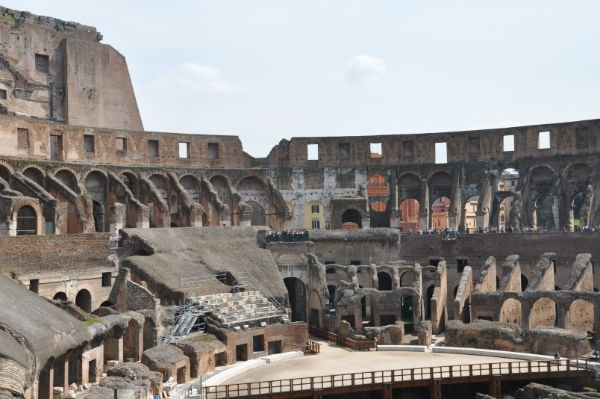

In [6]:
# Uploading Image to be analysed
image_file = 'Images/landmark.jpg'

# Viewing the image file
img(image_file)

## Analyse the image for the features specified above:

In [7]:
# Get image analysis
with open(image_file, mode="rb") as image_data:
    # call the API.
    # The first argument in the function is the image to be analysed. The second argument is the list of features to be extracted from this image.
    # We will run the analysis once per image. Then, we will display each feature in a new cell.
    analysis = computervision_client.analyze_image_in_stream(image_data ,features)

In [8]:
print(analysis.description.captions)

## 1. Image description

In [9]:
# Get image description
if (len(analysis.description.captions) > 0):
    print("Describing the image: ")
    for caption in analysis.description.captions:
        print("Description: '{}' (confidence: {:.2f}%)".format(caption.text, caption.confidence * 100))
else:
    print('No description found.')

Describing the image: 
Description: 'an ancient city with many ruins with Colosseum in the background' (confidence: 33.80%)


## 2. Feature Tagging

In [10]:
# Get image tags
if (len(analysis.tags) > 0):
    print("These are the tags associated with the image:")
    for tag in analysis.tags:
        print(" -'{}' (confidence: {:.2f}%)".format(tag.name, tag.confidence * 100))
else:
    print("No image tags found")

These are the tags associated with the image:
 -'outdoor' (confidence: 99.00%)
 -'building' (confidence: 98.81%)
 -'sky' (confidence: 98.21%)
 -'stadium' (confidence: 98.17%)
 -'ancient rome' (confidence: 96.16%)
 -'ruins' (confidence: 95.04%)
 -'amphitheatre' (confidence: 93.99%)
 -'ancient roman architecture' (confidence: 92.65%)
 -'historic site' (confidence: 89.55%)
 -'ancient history' (confidence: 89.54%)
 -'history' (confidence: 86.72%)
 -'archaeological site' (confidence: 84.41%)
 -'travel' (confidence: 65.85%)
 -'large' (confidence: 61.02%)
 -'city' (confidence: 56.57%)


## 3. Image Categorization, and Landmark Identification

In [11]:
# Get image categories
if (len(analysis.categories) > 0):
    print("Categories:")
    landmarks = []
    for category in analysis.categories:
        # Print the category
        print(" -'{}' (confidence: {:.2f}%)".format(category.name, category.score * 100))
        if category.detail:
            # Get landmarks in this category
            if category.detail.landmarks:
                for landmark in category.detail.landmarks:
                    if landmark not in landmarks:
                        landmarks.append(landmark)

    # If there were landmarks, list them
    if len(landmarks) > 0:
        print("Landmarks:")
        for landmark in landmarks:
            print(" -'{}' (confidence: {:.2f}%)".format(landmark.name, landmark.confidence * 100))
else:
    print("Unable to find image categories.")

Categories:
 -'building_' (confidence: 31.64%)
 -'others_' (confidence: 0.39%)
 -'outdoor_' (confidence: 3.91%)
Landmarks:
 -'Colosseum' (confidence: 93.70%)


## 4. Object Detection

In [12]:
'''
Object Detection
This example locates objects, identifies them, and draws bounding boxes around them in a local image.
'''
print("===== Object Detection =====")
# Get objects in the image
if len(analysis.objects) > 0:
    print("Objects in image:")

    # Prepare image for drawing
    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')
    image = Image.open(image_file)
    draw = ImageDraw.Draw(image)
    color = 'cyan'
    for detected_object in analysis.objects:
        # Print object name
        print(" -{} (confidence: {:.2f}%)".format(detected_object.object_property, detected_object.confidence * 100))

        # Draw object bounding box
        r = detected_object.rectangle
        bounding_box = ((r.x, r.y), (r.x + r.w, r.y + r.h))
        draw.rectangle(bounding_box, outline=color, width=3)
        plt.annotate(detected_object.object_property,(r.x, r.y), backgroundcolor=color)
    # Save annotated image
    plt.imshow(image)

    # Save the annotated image in a new file for future reference
    outputfile = 'objects.jpg'
    fig.savefig(outputfile)
    print('  Results saved in', outputfile)
else:
    print('No objects found in the image.')

===== Object Detection =====
No objects found in the image.


## 5. Content Moderation

In [13]:
'''
Content moderation
This example gives content ratings of a local image.
'''
print("===== Content moderation =====")
# Get moderation ratings
ratings = 'Ratings:\n -Adult: {}\n -Racy: {}\n -Gore: {}'.format(analysis.adult.is_adult_content,
                                                                    analysis.adult.is_racy_content,
                                                                    analysis.adult.is_gory_content)
print(ratings)

===== Content moderation =====
Ratings:
 -Adult: False
 -Racy: False
 -Gore: False


## 6. Brand detection

In [14]:
'''
Detect brands
This example detects brands in a local image.
'''
print("===== Detect brands =====")

# Get brands in the image
if (len(analysis.brands) > 0):
    print("Brands: ")
    for brand in analysis.brands:
        print(" -'{}' (confidence: {:.2f}%)".format(brand.name, brand.confidence * 100))
else:
    print("No brands detected in image.")

===== Detect brands =====
No brands detected in image.


## 7. Thumbnail Creation

In [15]:
'''
Generate a thumbnail image
This example creates a thumbnail of a local image.
'''
print("===== Generate Thumbnail =====")
# Generate a thumbnail
with open(image_file, mode="rb") as image_data:
    # Get thumbnail data
    thumbnail_stream = computervision_client.generate_thumbnail_in_stream(100, 100, image_data, True)

# Save thumbnail image
thumbnail_file_name = 'thumbnail.png'
with open(thumbnail_file_name, "wb") as thumbnail_file:
    for chunk in thumbnail_stream:
        thumbnail_file.write(chunk)

print('Thumbnail saved in', thumbnail_file_name)

===== Generate Thumbnail =====
Thumbnail saved in thumbnail.png


## Color Detection

In [16]:
'''
Detect Color
This example detects the different aspects of its color scheme in a local image.
'''
print("===== Detect Color =====")
# Open local image
local_image = open(image_file, "rb")
# Select visual feature(s) you want
local_image_features = ["color"]
# Call API with local image and features
detect_color_results_local = computervision_client.analyze_image_in_stream(local_image, local_image_features)

# Print results of the color scheme detected
print("Getting color scheme of the local image: ")
print("Is black and white: {}".format(detect_color_results_local.color.is_bw_img))
print("Accent color: {}".format(detect_color_results_local.color.accent_color))
print("Dominant background color: {}".format(detect_color_results_local.color.dominant_color_background))
print("Dominant foreground color: {}".format(detect_color_results_local.color.dominant_color_foreground))
print("Dominant colors: {}".format(detect_color_results_local.color.dominant_colors))
print()

===== Detect Color =====
Getting color scheme of the local image: 
Is black and white: False
Accent color: 486A83
Dominant background color: White
Dominant foreground color: Grey
Dominant colors: ['Grey', 'White']



In [19]:
image_file = 'Images/celebrities.jpg'

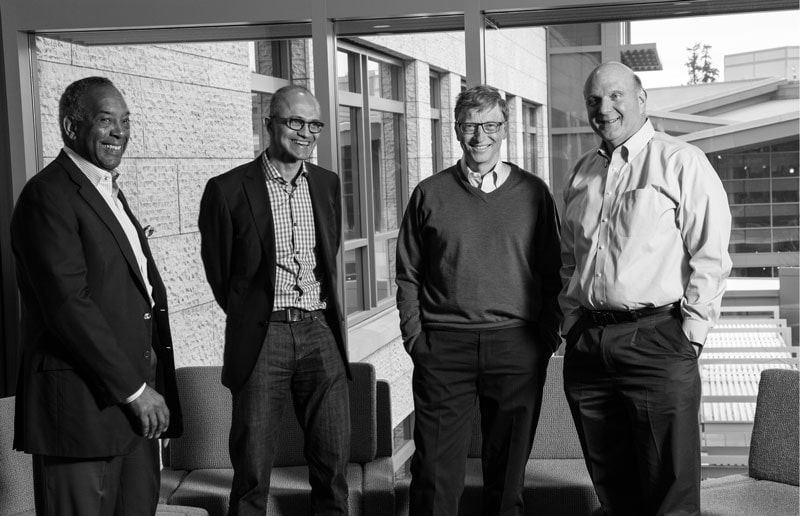

In [20]:
img(image_file)

## Image Type Detection

In [21]:
'''
Detect Image Types
This example detects an image's type (clip art/line drawing).
'''
print("===== Detect Image Types =====")
# Open local image
local_image_type = open(image_file, "rb")
# Select visual feature(s) you want
local_image_features = ["ImageType"]
# Call API with local image and features
detect_type_results_local = computervision_client.analyze_image_in_stream(local_image_type, local_image_features)

# Print type results with degree of accuracy
print("Type of local image:")
if detect_type_results_local.image_type.clip_art_type == 0:
    print("Image is not clip art.")
elif detect_type_results_local.image_type.line_drawing_type == 1:
    print("Image is ambiguously clip art.")
elif detect_type_results_local.image_type.line_drawing_type == 2:
    print("Image is normal clip art.")
else:
    print("Image is good clip art.")

if detect_type_results_local.image_type.line_drawing_type == 0:
    print("Image is not a line drawing.")
else:
    print("Image is a line drawing")

===== Detect Image Types =====
Type of local image:
Image is not clip art.
Image is not a line drawing.


## Brand Detection - Example 2

In [22]:
image_file = 'Images/objects.jpg'

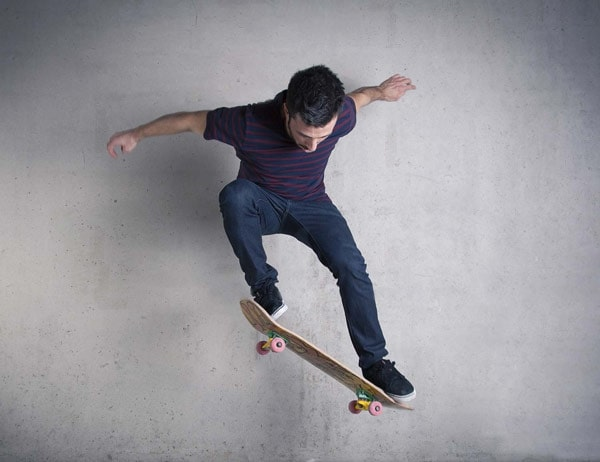

In [23]:
img(image_file)

In [24]:
'''
Detect brands
This example detects brands in a local image. If any brands are found, then they are identified and a bounding box is drawn around them.
'''
print("===== Detect brands =====")
# Open local image
local_image_type = open(image_file, "rb")
# Select visual feature(s) you want
local_image_features = ["brands"]
# Call API with local image and features
detect_type_results_local = computervision_client.analyze_image_in_stream(local_image_type, local_image_features)
# Get brands in the image
if (len(detect_type_results_local.brands) > 0):
    print("Brands: ")

    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')
    image = Image.open(image_file)
    draw = ImageDraw.Draw(image)
    color = 'cyan'
    for brand in detect_type_results_local.brands:
       # Prepare image for drawing
        print(" -'{}' (confidence: {:.2f}% at location {}, {}, {}, {})".format(brand.name, \
        brand.confidence * 100, brand.rectangle.x, brand.rectangle.x + brand.rectangle.w, \
        brand.rectangle.y, brand.rectangle.y + brand.rectangle.h))
        # Draw object bounding box
        r =  brand.rectangle
        bounding_box = ((r.x, r.y), (r.x + r.w, r.y + r.h))
        draw.rectangle(bounding_box, outline=color, width=3)
        plt.annotate(brand.name,(r.x, r.y), backgroundcolor=color)
    # Save annotated image
    plt.imshow(image)

    # Save the annotated image in a new file for future reference
    outputfile = 'brands_annotated.jpg'
    fig.savefig(outputfile)
    print('  Results saved in', outputfile)
else:
  print("No brands detected.")


===== Detect brands =====
No brands detected.


In [25]:
print(detect_type_results_local.description)

None


# Closing the project - resource deletion

In [ ]:
img('cv_del.png')